In [ ]:
"""
This script demonstrates that dimensionality is driven by a few cells. 
It does this by rescaling all data by Standard scalar, giving each cell unit covariance.
Under this conditions, dimensionality shoots up. 

Created by Yoni Browning, August 2018
"""

In [68]:
#%load_ext autoreload
#%autoreload 2
import matplotlib as mpl
import scipy as sp
import numpy as np
import pandas as pd
# sometimes order maters on these
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.neural_analysis as obna
import oBehave.behavior_analysis as obba
import sklearn.decomposition as decomp


from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

#experiment_id = 639438856# experiment B
experiment_id = 639253368# experiment A

In [69]:
# get a subset of the manifest for analysis
manifest = obhf.load_manifest()
obba.includeNovelSession(manifest);
use_manifest = manifest[(manifest.targeted_structure=='VISp')&manifest.cre_line.str.contains('Slc')&(manifest.first_session)]

In [70]:
# get some example data to play with
dataset= VisualBehaviorOphysDataset(experiment_id=experiment_id, cache_dir=obhf.drive_path)
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [71]:
# import sklearn packages
from sklearn.model_selection import train_test_split
import sklearn.decomposition as decomp
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [94]:
# Define two pipelines
scaler_pipeline = Pipeline((
    ('rescaler', StandardScaler()),
    ('reducer', decomp.PCA())
))
bland_pca = decomp.PCA()

In [95]:
# Functions needed to get mean resonse array for analysis below.
def killnancells(dataset,analysis):
    bad_cell_indices = []
    bad_cell_ids = []
    for cell_index in range(dataset.dff_traces[1].shape[0]):
        if np.isnan(dataset.dff_traces[1][cell_index][0]): #check whether first datapoint is nan
           bad_cell_indices.append(cell_index)
           bad_cell_ids.append(dataset.get_cell_specimen_id_for_cell_index(cell_index))
    fdf = analysis.flash_response_df.copy()
    fdf = fdf[fdf.cell.isin(bad_cell_indices)==False]
    return fdf 

def getResponseArray(dataset,analysis):
    num_trials = len(dataset.stimulus_table)
    fr = killnancells(dataset,analysis)
    use_cells = np.unique(fr.cell)
    response_array = np.empty((num_trials,len(use_cells)))
    for i in range(num_trials):
        response_array[i,:] = fr[fr.flash_number==i].mean_response.values
    return response_array

In [96]:
# get response array
response_array = getResponseArray(dataset,analysis)

In [97]:
# do fit on example data
scaler_pipeline.fit(response_array);
bland_pca.fit(response_array);

In [98]:
# check dimensionality of example data
sPCA = scaler_pipeline.named_steps['reducer']

D_scaler = 1/sum((sPCA.explained_variance_ratio_)**2.)
print(D_scaler)
D_bland = 1/sum((bland_pca.explained_variance_ratio_)**2.)
print(D_bland)

35.491375818247256
5.8476113181629215


In [78]:
# repeat Standard Scalar PCA for all data in manifest subset
keylist = ['experiment_id','session_type','targeted_structure','cre_line','dimension','dimension_ss']
dim = {k:[]for k in keylist}
for ii, rows in manifest.iterrows():
    if rows.first_session:
        dataset= VisualBehaviorOphysDataset(experiment_id=rows.experiment_id, cache_dir=obhf.drive_path)
        analysis = ResponseAnalysis(dataset)
        num_trials = len(dataset.stimulus_table)
        fr = killnancells(dataset,analysis)
        use_cells = np.unique(fr.cell)
        response_array = np.empty((num_trials,len(use_cells)))
        for i in range(num_trials):
            response_array[i,:] = fr[fr.flash_number==i].mean_response.values
        PCA = decomp.PCA()
        scaler_pipeline = Pipeline((
            ('rescaler', StandardScaler()),
            ('reducer', decomp.PCA())
        ))
        PCA.fit(response_array)
        scaler_pipeline.fit(response_array)
        D = 1/sum((PCA.explained_variance_ratio_)**2.)
        Ds = 1/sum((scaler_pipeline.named_steps['reducer'].explained_variance_ratio_)**2.)
        ##
        dim['experiment_id'].append(rows.experiment_id)
        dim['session_type'].append(rows.session_type)
        dim['targeted_structure'].append(rows.targeted_structure)
        dim['cre_line'].append(rows.cre_line)
        dim['dimension'].append(D)
        dim['dimension_ss'].append(Ds)

        print(rows.session_type+','+ rows.cre_line  +','+rows.targeted_structure+ ' : ' + str(dim['dimension'][-1])+' ; '+str(dim['dimension_ss'][-1]))

loading trial response dataframe
loading flash response dataframe
behavior_session_A,Vip-IRES-Cre,VISp : 3.2291406804901905 ; 3.87613206254561
loading trial response dataframe
loading flash response dataframe
behavior_session_B,Vip-IRES-Cre,VISp : 1.795595541642763 ; 3.142215654692451
loading trial response dataframe
loading flash response dataframe
behavior_session_C,Vip-IRES-Cre,VISp : 2.699735657411471 ; 4.2383902145753085
loading trial response dataframe
loading flash response dataframe
behavior_session_D,Vip-IRES-Cre,VISp : 3.742529315692777 ; 4.238282073723826
loading trial response dataframe
loading flash response dataframe
behavior_session_A,Vip-IRES-Cre,VISp : 2.151084195376867 ; 4.7282421807505575
loading trial response dataframe
loading flash response dataframe
behavior_session_B,Vip-IRES-Cre,VISp : 3.3150292999603943 ; 6.768158328373369
loading trial response dataframe
loading flash response dataframe
behavior_session_C,Vip-IRES-Cre,VISp : 4.542828287513398 ; 5.879012648576

In [ ]:
DimFrame = pd.DataFrame(dim)

In [79]:
# plot retular dimensionality (similar to DimAnalysis1 script)
behs = ['behavior_session_A','behavior_session_B','behavior_session_C','behavior_session_D']
scat = []
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for ii,s in enumerate(behs):
    this_data = DimFrame[(DimFrame.targeted_structure=='VISp')
                         &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                         &(DimFrame['session_type']==s)]['dimension'].values
    scat.append(this_data)
    #print(this_data)
    plt.scatter(ii*np.ones((len(this_data),1)),this_data,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data))#np.oness((len(this_data),)))
    plt.bar(ii,np.mean(this_data),yerr = sp.std(this_data),color = colorlist[ii])
plt.xticks([0,1,2,3],['A','B','C','D'])
plt.ylabel('Estimated Experiment Dim')
plt.xlabel('Behavior Session Type')
plt.title('VIP, VISal')

NameError: name 'DimFrame' is not defined

In [1]:
# Plot standard scalar dimensionality 
behs = ['behavior_session_A','behavior_session_B','behavior_session_C','behavior_session_D']
scat = []
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']
for ii,s in enumerate(behs):
    this_data = DimFrame[(DimFrame.targeted_structure=='VISp')
                         &(DimFrame['cre_line']=='Slc17a7-IRES2-Cre')#'Vip-IRES-Cre')#'Vip-IRES-Cre')#
                         &(DimFrame['session_type']==s)]['dimension_ss'].values
    scat.append(this_data)
    #print(this_data)
    plt.scatter(ii*np.ones((len(this_data),1)),this_data,color = 'K',marker = 'o',zorder = 3,s = [150]*len(this_data))#np.oness((len(this_data),)))
    plt.bar(ii,np.mean(this_data),yerr = sp.std(this_data),color = colorlist[ii])
plt.xticks([0,1,2,3],['A','B','C','D'])
plt.ylabel('Estimated Experiment Dim')
plt.xlabel('Behavior Session Type')
plt.title('Slc, VISp,StandardScalar')

NameError: name 'plt' is not defined

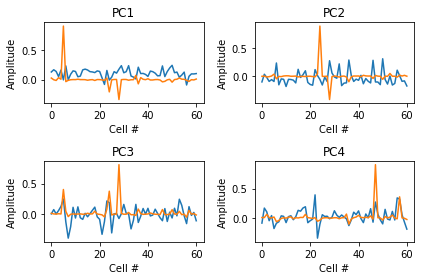

In [131]:
# visualize PCs with and without standard scalar.
#fig = plt.figure()
fig,ax = plt.subplots(2,2);
ax = ax.flatten()
for ii,a in enumerate(ax):
    ax[ii].plot(scaler_pipeline.named_steps['reducer'].components_[ii,:].T)
    ax[ii].plot(bland_pca.components_[ii,:].T)
    ax[ii].set_xlabel('Cell #')
    ax[ii].set_ylabel('Amplitude')
    ax[ii].set_title('PC'+str(ii+1))
fig.tight_layout()